In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [ ]:
!unzip ./Data/CatsDogs/train.zip -d ./Data/CatsDogs
!unzip ./Data/CatsDogs/test1.zip -d ./Data/CatsDogs

In [3]:
%matplotlib inline
tr_dir = './Data/CatsDogs/train'
ts_dir = './Data/CatsDogs/train'
tr_imgs = [f'{tr_dir}/{i}' for i in os.listdir(tr_dir)]


In [4]:
np.random.shuffle(tr_imgs)

In [5]:
train = int(len(tr_imgs) * 0.75)
val = int(len(tr_imgs) * 0.15)

tr_train = tr_imgs[:train]
tr_val = tr_imgs[train:train + val]
tr_test = tr_imgs[train + val:]

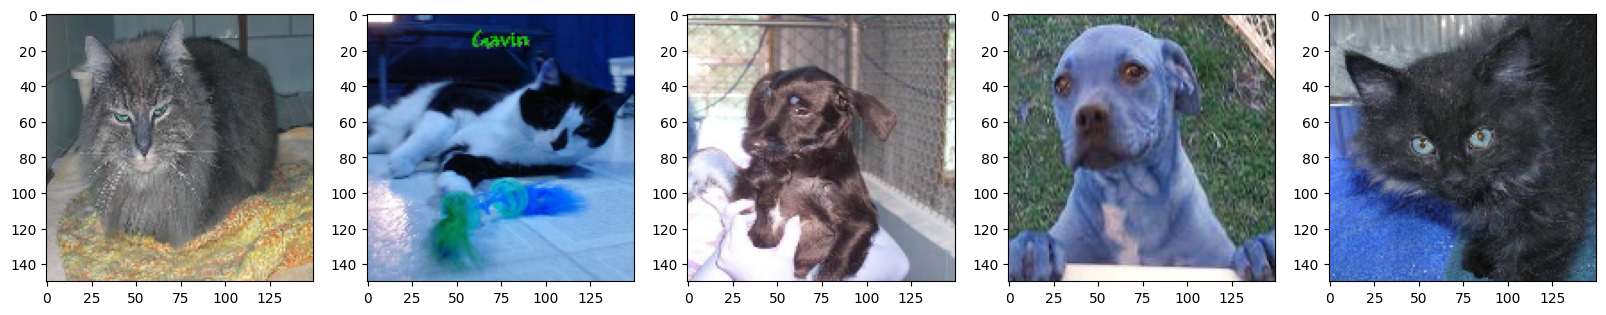

In [6]:
def process_imgs(imgs, width=150, height=150):
    x = []
    y = []
    for i in imgs:
        x.append(cv2.resize(cv2.imread(
                i, cv2.IMREAD_COLOR), (width, height),
                interpolation=cv2.INTER_CUBIC))
        label = 1 if 'dog' in i else 0
        y.append(label)
    return np.array(x), np.array(y)

tr_x, tr_y = process_imgs(tr_train)
tv_x, tv_y = process_imgs(tr_val)
ts_x, ts_y = process_imgs(tr_test)

# plot random images
plt.figure(figsize=(20, 10))
cols = 5
for i in range(cols):
    plt.subplot(int(5 / cols+1), cols, i+1)
    plt.imshow(tr_x[i])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

batch_size = 32

tr_data = ImageDataGenerator(rescale=1/255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
tv_data = ImageDataGenerator(rescale=1/255)

tr_gen = tr_data.flow(tr_x, tr_y, batch_size=batch_size)    
tv_gen = tv_data.flow(tv_x, tv_y, batch_size=batch_size)

In [8]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers, models

def gen_model():
    base=InceptionResNetV2(weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3))
    model = models.Sequential()
    model.add(base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    base.trainable = False
    return model


In [35]:
model = gen_model()
model.summary()

In [37]:
from tensorflow.keras import optimizers

epochs = 5

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=2e-5),
                metrics=['acc'])
hist = model.fit(tr_gen, validation_data=tv_gen,
                #steps_per_epoch=tr_x.shape[0] // batch_size,
                epochs=epochs)    

Epoch 1/5
586/586 [==============================] - 91s 139ms/step - loss: 0.6526 - acc: 0.9069 - val_loss: 0.0976 - val_acc: 0.9624
Epoch 2/5
586/586 [==============================] - 78s 133ms/step - loss: 0.1631 - acc: 0.9284 - val_loss: 0.0851 - val_acc: 0.9648
Epoch 3/5
586/586 [==============================] - 78s 134ms/step - loss: 0.1554 - acc: 0.9338 - val_loss: 0.0912 - val_acc: 0.9661
Epoch 4/5
586/586 [==============================] - 80s 136ms/step - loss: 0.1559 - acc: 0.9338 - val_loss: 0.0986 - val_acc: 0.9595
Epoch 5/5
586/586 [==============================] - 80s 136ms/step - loss: 0.1497 - acc: 0.9381 - val_loss: 0.0824 - val_acc: 0.9675


<Figure size 640x480 with 0 Axes>

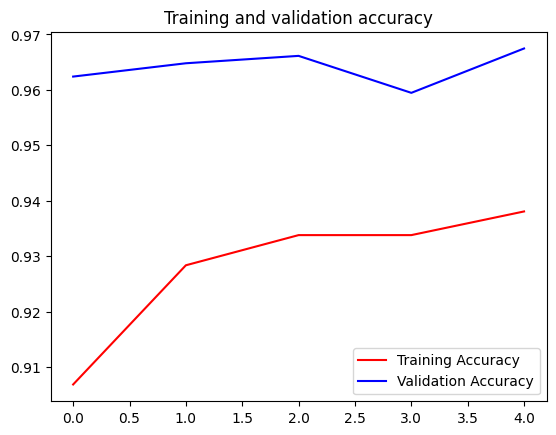

<Figure size 640x480 with 0 Axes>

In [53]:
plt.plot(range(epochs), hist.history['acc'], 'r', label="Training Accuracy")
plt.plot(range(epochs), hist.history['val_acc'], 'b', label="Validation Accuracy")
plt.legend()
plt.title('Training and validation accuracy')
plt.figure()

In [46]:
pr_yclass = model.predict(ts_x/255)

79/79 [==============================] - 6s 35ms/step


In [47]:
pr_y = np.argmax(pr_yclass, axis=1)

In [48]:
tf.math.confusion_matrix(ts_y, pr_y)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1177,   78],
       [  22, 1223]], dtype=int32)>

In [51]:
(pr_y==ts_y).sum()/len(ts_y)

0.96